Okay, a first attempt at using this $S(q,\omega)$ pipeline to analyze Bill Bement's oocyte wound healing data.

In [5]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
# let matplotlib plot interactively in notebook
%matplotlib notebook

# Tweak styles
#mpl.rc('figure', figsize=(10,6))
mpl.rc('image',cmap='inferno')

import numpy as np
import scipy.integrate as integrate

import pims
import dynamicstructurefactor.sqw as sqw

savestuff = False
bementDataPath = '/Users/Danny/Dropbox/Excitable wounds for Mike and Ian/'

In [6]:
# List of movie names, microns per pixels, and boolean for wounding
movieNames = ['AVG_071714ect2-001.xml - C=0.tif', 'AVG_071714ect2-001.xml - C=1.tif',
             'AVG_071714ect2-009.xml - C=0.tif', 'AVG_071714ect2-009.xml - C=1.tif',
             'AVG_071714ect2-012.xml - C=0.tif', 'AVG_071714ect2-012.xml - C=1.tif',
             'AVG_071714ect2-014.xml - C=0.tif', 'AVG_071714ect2-014.xml - C=1.tif',
             'AVG_071714ect2-026.xml - C=0.tif', 'AVG_071714ect2-026.xml - C=1.tif',
             'AVG_071714ect2-027.xml - C=0.tif', 'AVG_071714ect2-027.xml - C=1.tif',
             'AVG_C1-071714ect2-013.tif', 'AVG_C2-071714ect2-013.tif',
             'AVG_C1-eaect1-005.tif', 'AVG_C2-eaect1-005.tif',
             'AVG_C1-eaect1-010.tif', 'AVG_C2-eaect1-010.tif',
             'AVG_C1-ect2-004.tif', 'AVG_C2-ect2-004.tif',
             'AVG_eaect1-007.xml - C=0.tif', 'AVG_eaect1-007.xml - C=1.tif']

umpxList = np.array([
    0.1922, 0.1922,
    0.1922, 0.1922,
    0.1538, 0.1538,
    0.3434, 0.3434,
    0.3808, 0.3808,
    0.3808, 0.3808,
    0.1922, 0.1922,
    0.1922, 0.1922,
    0.3232, 0.3232,
    0.1922, 0.1922,
    0.3232, 0.3232])

woundList = np.array([0,0,
                      1,1,
                      0,0,
                      0,0,
                      1,1,
                      1,1,
                      0,0,
                      0,0,
                      1,1,
                      1,1,
                      1,1])

firstWoundFrameList = np.array([np.nan, np.nan,
                                233, 233,
                                np.nan, np.nan,
                                np.nan, np.nan,
                                11, 11,
                                1, 1,
                                np.nan, np.nan,
                                np.nan, np.nan,
                                76, 76,
                                78, 78,
                                np.nan, np.nan])

firstSteadyStateFrame = np.array([np.nan, np.nan,
                                  270, 270,
                                  np.nan, np.nan,
                                  np.nan, np.nan,
                                  25, 25,
                                  1, 1,
                                  np.nan, np.nan,
                                  np.nan, np.nan,
                                  120, 120,
                                  np.nan, np.nan,
                                  1,1])

In [7]:
n = 2 # Which movie?

# if not os.path.exists(movieNames[n]+'/post/2dpowerspec') and woundList[n]:
#     os.makedirs(movieNames[n]+'/post/2dpowerspec')

# note that opening a tif stack automatically gives an array 
# of shape (t, x, y)
frameArray = pims.open(bementDataPath + movieNames[n])


print(movieNames[n])

AVG_071714ect2-009.xml - C=0.tif


Frame([[ 294,  431,  296, ...,  890,  765, 1023],
       [ 314,  352,  593, ...,  600,  620, 1043],
       [ 525,  391,  644, ..., 1112,  777, 1009],
       ..., 
       [ 442,  459,  538, ..., 1272, 1484, 1728],
       [ 801,  619,  697, ..., 1760, 1488, 1763],
       [ 483,  589,  438, ..., 1699, 1423, 1629]], dtype=uint16)
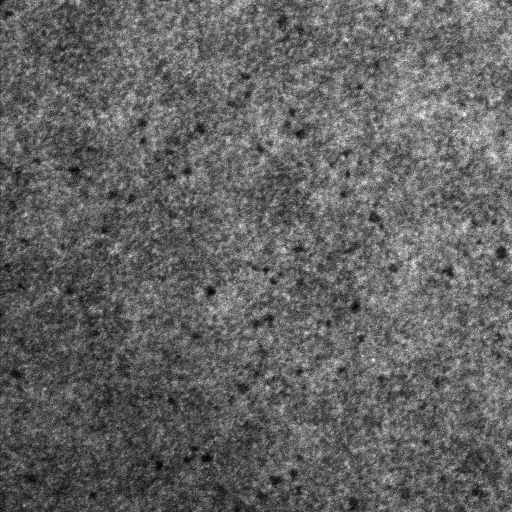

In [12]:
frameArray[0][0]

Here, we calculate everything we need. 

First, enter some parameters about the movie and whether we only want a subsection of the movie. 
Then, we get 
1. the coordinate system in Fourier space 
2. the power spectrum, which is what we call $S(\vec{q},\omega)$
3. it's azimuthal average $S(q,\omega)$
4. the static structure factor – $S(q) = \int d\omega S(q, \omega)$)
5. the normalized dynamic structure factor ($S(q,\omega)/S(q)$)

In [6]:
# Need some info of movies to get scales right
dt = 1 # one second per frame (a complete guess right now)
dx = umpxList[n] # um/pixel, from scale in image uploaded above

firstWithWound  = firstWoundFrameList[n]   # First frame with wound
firstAfterWound = firstSteadyStateFrame[n] # First frame when "steady state" is reached
                                           # This is arbitrarily chosen by eye...
if ~np.isnan(firstWoundFrameList[n]):
    # Switch these depending on which part of the movie you want to analyze
    pre = 1;
    post = 0;
    if pre:
        frameArray = frameArray[:firstWithWound, :, :]
    elif post:
        frameArray = frameArray[firstAfterWound:, :, :]

# note that opening a tif stack automatically gives an array of shape
# (t, x, y)
[nt, nx, ny] = frameArray.shape
#nt = frames[-1].frame_no+1

# Set up coordinate system in Fourier Space
qx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(nx, dx))
qy = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(ny, dx))
ww = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(nt, dt))

# Get power spectrum (aka S(q,w))
#frameArray = sqw.image2array(frames) # only if loading image sequence
frameArray = np.ndarray.astype(frameArray, float) - frameArray.mean()
framePSpec = sqw.powerSpectrum(frameArray, norm = True)

# Azimuthally average, then get normed spectrum and one-sided spectrum
aziAvg = sqw.azimuthalAverage3D(framePSpec, tdim = 0)

# Get static structure constant
sofcue = integrate.trapz(aziAvg, ww, axis=0)

# Get normalized dynamic structure factor
normed = aziAvg/sofcue[:,None].T

oneSidedNormed = normed[int(np.floor(nt/2)):-1,:]
qxOneSided = np.fft.ifftshift(qx)[:int(np.floor(qx.size/2))]
wwOneSided = np.fft.ifftshift(ww)[:int(np.floor(ww.size/2))]

/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Now we go through different plots. The first is of the the power spectrum with the option to save an image sequence to see all frequency slices of it.

Next is plotting the azimuthally averaged dynamic structure factor.

Next is plotting the static structure factor. 

Finally is plotting the normalized dynamic structure factor.

In [ ]:
# Plot full power spectrum

fig1, ax1 = plt.subplots()
randw = int(np.floor(np.random.rand()*nt))

cax1 = ax1.pcolorfast(qx, qy, (framePSpec[randw,:,:]), vmax = 0.5)
ax1.set_xlabel('$q_x \; (rad/\mu m)$')
ax1.set_ylabel('$q_y \; (rad/\mu m)$')
ax1.set_title('$|\mathcal{F}|^2(q_x, q_y)$, at $\omega$ = ' +
              str(randw) + ' rad/min')
ax1.set_aspect('equal')
cbar = fig1.colorbar(cax1, extend='max')

if savestuff:
    for ii in range(0,nt):
        fig1, ax1 = plt.subplots()
        cax1 = ax1.pcolorfast(qx, qy, (framePSpec[ii,:,:]), vmax = 0.1)
        ax1.set_xlabel('$q_x \; (rad/\mu m)$')
        ax1.set_ylabel('$q_y \; (rad/\mu m)$')
        ax1.set_title('$|\mathcal{F}|^2(q_x, q_y)$, at $\omega$ = ' +
                      str(ww[ii]) + ' rad/min')
        ax1.set_aspect('equal')

        cbar = fig1.colorbar(cax1, extend='max')
        fig1.savefig(movieNames[n] +'/post/2dpowerspec/2dPSD_'+ str(ii) +
                     '.png', format = 'png')
        plt.close(fig1)

In [ ]:
# Plot static structure constant S(q)

sofcueFig, sofcueAx = plt.subplots()
sofcueAx.plot(sofcue)
sofcueAx.set_xlabel('$q \; (rad/\mu m)$')
sofcueAx.set_ylabel('$S(q)$')
sofcueAx.set_title('Static Structure Factor ' + movieNames[n])

if savestuff:
    sofcueFig.savefig(movieNames[n] + '/post/sofq_' + movieNames[n] +
                      '.eps',format = 'eps')
    sofcueFig.savefig(movieNames[n] + '/post/sofq_' + movieNames[n] +
                      '.tif',format = 'tif')

In [ ]:
# Plot one-sided S(q,w)

heatFig, heatAx = plt.subplots()
# caxHeat = heatAx.pcolorfast(qxOneSided[:], wwOneSided[:],
#                         2*(aziAvg[wwOneSided.size+1:,
#                                           1:qxOneSided.size]),
#                            vmax = aziAvg.mean())

caxHeat = heatAx.pcolorfast(qxOneSided, wwOneSided,
                            2*((aziAvg[wwOneSided.size:,:])),
                            vmax = aziAvg.mean()/.25)


heatAx.set_xlabel('$|q| \; (rad/\mu m)$')
heatAx.set_ylabel('$\omega \; (rad/sec)$')
heatAx.set_title('$S(q,\omega)$, ' + movieNames[n])
#heatAx.set_xlim(0,150)

cbarNormed = heatFig.colorbar(caxHeat, extend = 'max')

if savestuff:
    heatFig.savefig(movieNames[n] + '/post/sqw_' + movieNames[n] +
                    '.eps', format = 'eps')
    heatFig.savefig(movieNames[n] + '/post/sqw_' + movieNames[n] +
                    '.tif', format = 'tif')

#plt.close('all')
print('done')

<IPython.core.display.Javascript object>


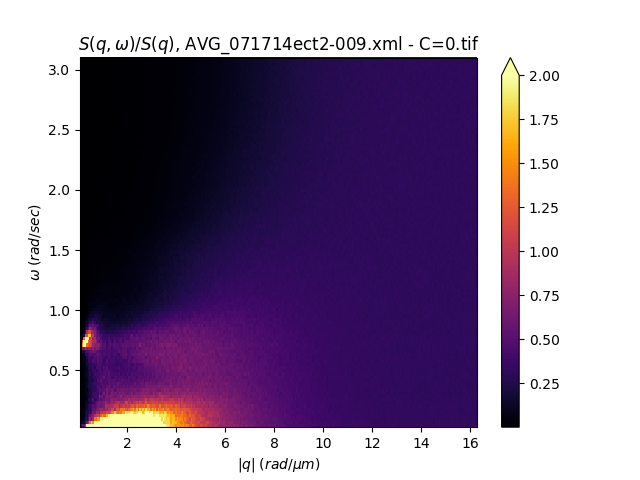

done


In [10]:
# Plot one-sided normed S(q,w)/S(q)

heatFig, heatAx = plt.subplots()
caxHeat = heatAx.pcolorfast(qxOneSided[1:], wwOneSided[1:],
                        2*(oneSidedNormed[1:wwOneSided.size,
                                          1:qxOneSided.size]),
                           vmax = 2, cmap='inferno')

heatAx.set_xlabel('$|q| \; (rad/\mu m)$')
heatAx.set_ylabel('$\omega \; (rad/sec)$')
heatAx.set_title('$S(q,\omega)/S(q)$, ' + movieNames[n])
#heatAx.set_xlim(0,150)

cbarNormed = heatFig.colorbar(caxHeat, extend = 'max')
savestuff = 1
if savestuff:
    heatFig.savefig(movieNames[n] + '/pre/sqwNormed_' + movieNames[n] +
                    '.eps', format = 'eps')
    heatFig.savefig(movieNames[n] + '/pre/sqwNormed_' + movieNames[n] +
                    '.tif', format = 'tif')

#plt.close('all')
print('done')

And finally, save all the data.

In [ ]:
# Save data
savestuff = True
if savestuff:
    np.savetxt(movieNames[n]+'/normedSQW.txt', normed,
               header = 'S(q,w)/S(q) for ' + movieNames[n] + ', no wounding')
    np.savetxt(movieNames[n]+'/qArray.txt', qxOneSided,
               header = 'Wave vectors for '+ movieNames[n]+ ', no wounding')
    np.savetxt(movieNames[n]+'/wArray.txt', ww,
               header = 'Frequencies for ' + movieNames[n]+ ', no wounding')
    np.savetxt(movieNames[n]+'/sqw.txt', aziAvg,
               header = 'Azimuthally averaged S(q,w) for ' + movieNames[n]+ ', no wounding')